## Transformers for Sentiment Analysis

In this notebook we will be using the transformer model, first introduced in [this](https://arxiv.org/abs/1706.03762) paper. Specifically, we will be using the BERT (Bidirectional Encoder Representations from Transformers) model from [this](https://arxiv.org/abs/1810.04805) paper. 

Transformer models are considerably larger than anything else covered in these tutorials. As such we are going to use the [transformers library](https://github.com/huggingface/transformers) to get pre-trained transformers and use them as our embedding layers. We will freeze (not train) the transformer and only train the remainder of the model which learns from the representations produced by the transformer. In this case we will be using a multi-layer bi-directional GRU, however any model can learn from these representations.

## Preparing Data

First, as always, let's set the random seeds for deterministic results.

In [2]:
import torch

import random
import numpy as np

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

ModuleNotFoundError: No module named 'torch'

The transformer has already been trained with a specific vocabulary, which means we need to train with the exact same vocabulary and also tokenize our data in the same way that the transformer did when it was initially trained.

Luckily, the transformers library has tokenizers for each of the transformer models provided. In this case we are using the BERT model which ignores casing (i.e. will lower case every word). We get this by loading the pre-trained `bert-base-uncased` tokenizer.

In [ ]:
!pip install transformers
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

     |████████████████████████████████| 3.1 MB 7.6 MB/s 
     |████████████████████████████████| 3.3 MB 47.0 MB/s 
     |████████████████████████████████| 895 kB 36.6 MB/s 
     |████████████████████████████████| 61 kB 511 kB/s 
     |████████████████████████████████| 596 kB 52.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

The `tokenizer` has a `vocab` attribute which contains the actual vocabulary we will be using. We can check how many tokens are in it by checking its length.

In [ ]:
len(tokenizer.vocab)

30522

Using the tokenizer is as simple as calling `tokenizer.tokenize` on a string. This will tokenize and lower case the data in a way that is consistent with the pre-trained transformer model.

In [ ]:
tokens = tokenizer.tokenize('Hello WORLD how ARE yoU?')

print(tokens)

['hello', 'world', 'how', 'are', 'you', '?']


We can numericalize tokens using our vocabulary using `tokenizer.convert_tokens_to_ids`.

In [ ]:
indexes = tokenizer.convert_tokens_to_ids(tokens)

print(indexes)

[7592, 2088, 2129, 2024, 2017, 1029]


The transformer was also trained with special tokens to mark the beginning and end of the sentence, detailed [here](https://huggingface.co/transformers/model_doc/bert.html#transformers.BertModel). As well as a standard padding and unknown token. We can also get these from the tokenizer.

**Note**: the tokenizer does have a beginning of sequence and end of sequence attributes (`bos_token` and `eos_token`) but these are not set and should not be used for this transformer.

In [ ]:
init_token = tokenizer.cls_token
eos_token = tokenizer.sep_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token

print(init_token, eos_token, pad_token, unk_token)

[CLS] [SEP] [PAD] [UNK]


We can get the indexes of the special tokens by converting them using the vocabulary...

In [ ]:
init_token_idx = tokenizer.convert_tokens_to_ids(init_token)
eos_token_idx = tokenizer.convert_tokens_to_ids(eos_token)
pad_token_idx = tokenizer.convert_tokens_to_ids(pad_token)
unk_token_idx = tokenizer.convert_tokens_to_ids(unk_token)

print(init_token_idx, eos_token_idx, pad_token_idx, unk_token_idx)

101 102 0 100


...or by explicitly getting them from the tokenizer.

In [ ]:
init_token_idx = tokenizer.cls_token_id
eos_token_idx = tokenizer.sep_token_id
pad_token_idx = tokenizer.pad_token_id
unk_token_idx = tokenizer.unk_token_id

print(init_token_idx, eos_token_idx, pad_token_idx, unk_token_idx)

101 102 0 100


Another thing we need to handle is that the model was trained on sequences with a defined maximum length - it does not know how to handle sequences longer than it has been trained on. We can get the maximum length of these input sizes by checking the `max_model_input_sizes` for the version of the transformer we want to use. In this case, it is 512 tokens.

In [ ]:
max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased']

print(max_input_length)

512


Previously we have used the `spaCy` tokenizer to tokenize our examples. However we now need to define a function that we will pass to our `TEXT` field that will handle all the tokenization for us. It will also cut down the number of tokens to a maximum length. Note that our maximum length is 2 less than the actual maximum length. This is because we need to append two tokens to each sequence, one to the start and one to the end.

In [ ]:
def tokenize_and_cut(sentence):
    tokens = tokenizer.tokenize(sentence) 
    tokens = tokens[:max_input_length-2]
    return tokens

Now we define our fields. The transformer expects the batch dimension to be first, so we set `batch_first = True`. As we already have the vocabulary for our text, provided by the transformer we set `use_vocab = False` to tell torchtext that we'll be handling the vocabulary side of things. We pass our `tokenize_and_cut` function as the tokenizer. The `preprocessing` argument is a function that takes in the example after it has been tokenized, this is where we will convert the tokens to their indexes. Finally, we define the special tokens - making note that we are defining them to be their index value and not their string value, i.e. `100` instead of `[UNK]` This is because the sequences will already be converted into indexes.

We define the label field as before.

In [ ]:
from torchtext.legacy import data

TEXT = data.Field(batch_first = True,
                  use_vocab = False,
                  tokenize = tokenize_and_cut,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = init_token_idx,
                  eos_token = eos_token_idx,
                  pad_token = pad_token_idx,
                  unk_token = unk_token_idx)

LABEL = data.LabelField(dtype = torch.float)

We load the data and create the validation splits as before.

In [ ]:
from torchtext.legacy import datasets

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

train_data, valid_data = train_data.split(random_state = random.seed(SEED))

downloading aclImdb_v1.tar.gz


100%|██████████| 84.1M/84.1M [00:01<00:00, 70.0MB/s]


In [ ]:
print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")

Number of training examples: 17500
Number of validation examples: 7500
Number of testing examples: 25000


We can check an example and ensure that the text has already been numericalized.

In [ ]:
print(vars(train_data.examples[6]))

{'text': [2023, 3185, 2003, 2028, 1997, 1996, 2087, 4895, 18447, 4765, 19301, 2135, 2919, 2895, 3152, 2412, 2404, 2000, 2143, 1012, 2079, 14277, 2232, 10424, 8004, 11528, 1005, 21860, 7389, 2007, 1037, 2887, 9669, 2003, 6057, 2438, 1010, 2021, 5587, 2428, 9781, 2100, 8937, 1011, 8937, 2895, 2000, 1996, 4666, 1010, 2019, 18080, 1998, 2058, 1011, 1996, 1011, 2327, 12700, 1010, 1037, 18856, 17322, 2094, 2293, 3037, 4942, 24759, 4140, 1998, 2028, 1997, 1996, 5409, 21306, 1997, 2035, 2051, 1010, 1998, 2017, 1005, 2310, 2288, 4426, 3243, 1996, 2210, 5920, 1011, 29290, 9526, 2005, 2111, 2040, 5959, 2037, 2166, 1998, 1010, 2039, 6229, 3666, 1000, 24419, 1010, 1000, 2018, 2196, 23133, 4288, 3209, 2007, 1037, 6271, 4263, 2818, 1012, 1026, 7987, 1013, 1028, 1026, 7987, 1013, 1028, 1045, 2123, 1005, 1056, 2113, 2065, 2009, 1005, 1055, 2074, 2033, 2021, 1996, 2878, 15667, 4942, 18209, 2003, 3904, 2205, 11259, 1012, 2045, 2024, 5377, 7604, 2000, 3287, 8991, 18400, 2401, 1010, 1998, 2025, 2011, 3801,

We can use the `convert_ids_to_tokens` to transform these indexes back into readable tokens.

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(vars(train_data.examples[6])['text'])

print(tokens)

['this', 'movie', 'is', 'one', 'of', 'the', 'most', 'un', '##int', '##ent', '##ional', '##ly', 'bad', 'action', 'films', 'ever', 'put', 'to', 'film', '.', 'do', '##lp', '##h', 'fr', '##ig', '##gin', "'", 'lund', '##ren', 'with', 'a', 'japanese', 'accent', 'is', 'funny', 'enough', ',', 'but', 'add', 'really', 'corn', '##y', 'buddy', '-', 'buddy', 'action', 'to', 'the', 'mix', ',', 'an', 'eccentric', 'and', 'over', '-', 'the', '-', 'top', 'villain', ',', 'a', 'cl', '##iche', '##d', 'love', 'interest', 'sub', '##pl', '##ot', 'and', 'one', 'of', 'the', 'worst', 'endings', 'of', 'all', 'time', ',', 'and', 'you', "'", 've', 'got', 'yourself', 'quite', 'the', 'little', 'suicide', '-', 'inducing', 'cure', 'for', 'people', 'who', 'enjoy', 'their', 'life', 'and', ',', 'up', 'till', 'watching', '"', 'showdown', ',', '"', 'had', 'never', 'contemplated', 'killing', 'themselves', 'with', 'a', 'blow', '##tor', '##ch', '.', '<', 'br', '/', '>', '<', 'br', '/', '>', 'i', 'don', "'", 't', 'know', 'if', 

Although we've handled the vocabulary for the text, we still need to build the vocabulary for the labels.

In [ ]:
LABEL.build_vocab(train_data)

In [ ]:
print(LABEL.vocab.stoi)

defaultdict(None, {'neg': 0, 'pos': 1})


As before, we create the iterators. Ideally we want to use the largest batch size that we can as I've found this gives the best results for transformers.

In [ ]:
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device)

## Build the Model

Next, we'll load the pre-trained model, making sure to load the same model as we did for the tokenizer.

In [ ]:
from transformers import BertTokenizer, BertModel

bert = BertModel.from_pretrained('bert-base-uncased')

ModuleNotFoundError: ignored

Next, we'll define our actual model. 

Instead of using an embedding layer to get embeddings for our text, we'll be using the pre-trained transformer model. These embeddings will then be fed into a GRU to produce a prediction for the sentiment of the input sentence. We get the embedding dimension size (called the `hidden_size`) from the transformer via its config attribute. The rest of the initialization is standard.

Within the forward pass, we wrap the transformer in a `no_grad` to ensure no gradients are calculated over this part of the model. The transformer actually returns the embeddings for the whole sequence as well as a *pooled* output. The [documentation](https://huggingface.co/transformers/model_doc/bert.html#transformers.BertModel) states that the pooled output is "usually not a good summary of the semantic content of the input, you’re often better with averaging or pooling the sequence of hidden-states for the whole input sequence", hence we will not be using it. The rest of the forward pass is the standard implementation of a recurrent model, where we take the hidden state over the final time-step, and pass it through a linear layer to get our predictions.

In [ ]:
import torch.nn as nn

class BERTGRUSentiment(nn.Module):
    def __init__(self,
                 bert,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout):
        
        super().__init__()
        
        self.bert = bert
        
        embedding_dim = bert.config.to_dict()['hidden_size']
        
        self.rnn = nn.GRU(embedding_dim,
                          hidden_dim,
                          num_layers = n_layers,
                          bidirectional = bidirectional,
                          batch_first = True,
                          dropout = 0 if n_layers < 2 else dropout)
        
        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [batch size, sent len]
                
        with torch.no_grad():
            embedded = self.bert(text)[0]
                
        #embedded = [batch size, sent len, emb dim]
        
        _, hidden = self.rnn(embedded)
        
        #hidden = [n layers * n directions, batch size, emb dim]
        
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
                
        #hidden = [batch size, hid dim]
        
        output = self.out(hidden)
        
        #output = [batch size, out dim]
        
        return output

Next, we create an instance of our model using standard hyperparameters.

In [ ]:
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.25

model = BERTGRUSentiment(bert,
                         HIDDEN_DIM,
                         OUTPUT_DIM,
                         N_LAYERS,
                         BIDIRECTIONAL,
                         DROPOUT)

We can check how many parameters the model has. Our standard models have under 5M, but this one has 112M! Luckily, 110M of these parameters are from the transformer and we will not be training those.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

In order to freeze paramers (not train them) we need to set their `requires_grad` attribute to `False`. To do this, we simply loop through all of the `named_parameters` in our model and if they're a part of the `bert` transformer model, we set `requires_grad = False`. 

In [ ]:
for name, param in model.named_parameters():                
    if name.startswith('bert'):
        param.requires_grad = False

We can now see that our model has under 3M trainable parameters, making it almost comparable to the `FastText` model. However, the text still has to propagate through the transformer which causes training to take considerably longer.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

We can double check the names of the trainable parameters, ensuring they make sense. As we can see, they are all the parameters of the GRU (`rnn`) and the linear layer (`out`).

In [ ]:
for name, param in model.named_parameters():                
    if param.requires_grad:
        print(name)

## Train the Model

As is standard, we define our optimizer and criterion (loss function).

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

In [ ]:
criterion = nn.BCEWithLogitsLoss()

Place the model and criterion onto the GPU (if available)

In [ ]:
model = model.to(device)
criterion = criterion.to(device)

Next, we'll define functions for: calculating accuracy, performing a training epoch, performing an evaluation epoch and calculating how long a training/evaluation epoch takes.

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finally, we'll train our model. This takes considerably longer than any of the previous models due to the size of the transformer. Even though we are not training any of the transformer's parameters we still need to pass the data through the model which takes a considerable amount of time on a standard GPU.

In [ ]:
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
        
    end_time = time.time()
        
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 7m 14s
	Train Loss: 0.474 | Train Acc: 75.97%
	 Val. Loss: 0.314 |  Val. Acc: 88.07%
Epoch: 02 | Epoch Time: 7m 14s
	Train Loss: 0.275 | Train Acc: 88.69%
	 Val. Loss: 0.238 |  Val. Acc: 90.51%
Epoch: 03 | Epoch Time: 7m 14s
	Train Loss: 0.228 | Train Acc: 90.87%
	 Val. Loss: 0.226 |  Val. Acc: 91.30%
Epoch: 04 | Epoch Time: 7m 14s
	Train Loss: 0.202 | Train Acc: 92.14%
	 Val. Loss: 0.212 |  Val. Acc: 91.68%
Epoch: 05 | Epoch Time: 7m 14s
	Train Loss: 0.176 | Train Acc: 93.19%
	 Val. Loss: 0.225 |  Val. Acc: 91.55%


We'll load up the parameters that gave us the best validation loss and try these on the test set - which gives us our best results so far!

In [ ]:
model.load_state_dict(torch.load('tut6-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.200 | Test Acc: 92.08%


## Inference

We'll then use the model to test the sentiment of some sequences. We tokenize the input sequence, trim it down to the maximum length, add the special tokens to either side, convert it to a tensor, add a fake batch dimension and then pass it through our model.

In [ ]:
def predict_sentiment(model, tokenizer, sentence):
    model.eval()
    tokens = tokenizer.tokenize(sentence)
    tokens = tokens[:max_input_length-2]
    indexed = [init_token_idx] + tokenizer.convert_tokens_to_ids(tokens) + [eos_token_idx]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    prediction = torch.sigmoid(model(tensor))
    return prediction.item()

In [ ]:
predict_sentiment(model, tokenizer, "This film is terrible")

0.05608946830034256

In [ ]:
predict_sentiment(model, tokenizer, "This film is great")

0.9099361896514893

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd

path = '/content/drive/My Drive/Colab Notebooks/'

omicron = pd.read_csv(path + 'omicron.csv', encoding = 'cp437')

In [ ]:
for i in range(len(omicron)):
  omicron.iloc[i, 1] = predict_sentiment(model, tokenizer, str(omicron.iloc[i, 0]))

In [ ]:
omicron['predict'].mean()

0.5724332512556566

In [ ]:
omicron

,data,predict
0,3rd week of omicron no deaths reported common ...,0.211134
1,a technology that alerts and detects viruses f...,0.632403
2,_here i wonder how can he find scientific to o...,0.340283
3,australia are currently in there 2 week period...,0.547367
4,you can still catch covid regardless the peopl...,0.467325
...,...,...
1009,less than 1% of people with post covid have be...,0.726166
1010,_clare dec2021 rising omicron and hospitals st...,0.766626
1011,as it stands having had delta variant does not...,0.515714
1012,delhi govt issues show cause notice to etihad ...,0.476572


In [ ]:
with open(path + 'Omicron.txt') as f:
    lines = f.readlines()

omicron = [line.rstrip('\n') for line in lines]

omicron = pd.DataFrame(omicron)

omicron['predict'] = 0

for i in range(len(omicron)):
  omicron.iloc[i, 1] = predict_sentiment(model, tokenizer, str(omicron.iloc[i, 0]))

In [ ]:
omicron['predict'].mean()

0.5830925456349255

In [ ]:
omicron

,0,predict
0,3rd week of omicron no deaths reported common ...,0.310935
1,a technology that alerts and detects viruses f...,0.632403
2,_here i wonder how can he find scientific to o...,0.340283
3,australia are currently in there 2 week period...,0.610694
4,you can still catch covid regardless the peopl...,0.467325
...,...,...
1009,less than 1% of people with post covid have be...,0.726166
1010,_clare dec2021 rising omicron and hospitals st...,0.766626
1011,as it stands having had delta variant does not...,0.515714
1012,delhi govt issues show cause notice to etihad ...,0.476572


In [ ]:
with open(path + 'Voca_in_Vaccinated.txt') as f:
    lines = f.readlines()

vaccinated = [line.rstrip('\n') for line in lines]

vaccinated_df = pd.DataFrame(vaccinated)

vaccinated_df['predict'] = 0

for i in range(len(vaccinated_df)):
  vaccinated_df.iloc[i, 1] = predict_sentiment(model, tokenizer, str(vaccinated_df.iloc[i, 0]))

In [ ]:
vaccinated_df['predict'].mean()

0.4975327602916615

In [ ]:
vaccinated_df

,0,predict
0,is the best defense against and let’s not forg...,0.486133
1,getting vaccinated reduces your chances and if...,0.146589
2,you just admitted that the fully vaccinated pe...,0.208701
3,we’ve locked up all the unvaccinated dirty low...,0.322740
4,covid 19 shows time and time again that your h...,0.380779
...,...,...
1000,nazis have no place in america the left called...,0.615516
1001,why are those of us who are vaccinated back to...,0.435970
1002,oh look j for life _spoor _knipe who blocked me,0.311948
1003,i work retail around a very unvaccinated popul...,0.585100


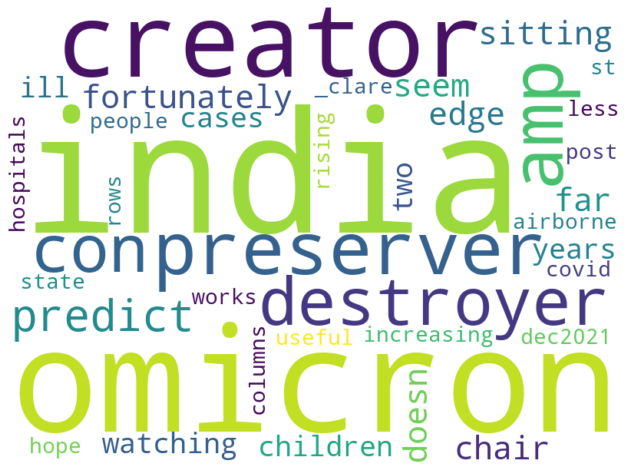

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


cloud = WordCloud(background_color='white', width=800, height=600).generate(str(omicron[omicron['predict'] > 0.7]))
cloud.to_file(filename = 'Vaccinated_0.7.png')
plt.figure(figsize=(11,11))
plt.axis('off')
plt.imshow(cloud, interpolation='bilinear')
plt.show()

In [ ]:
with open(path + 'Biden_words.txt') as f:
    lines = f.readlines()

biden = [line.rstrip('\n') for line in lines]

biden = pd.DataFrame(biden)

biden['predict'] = 0

for i in range(len(biden)):
  biden.iloc[i, 1] = predict_sentiment(model, tokenizer, str(biden.iloc[i, 0]))

In [ ]:
biden['predict'].mean()

0.6116106347739696

In [ ]:
biden

,0,predict
0,a thanksgiving message from the biden family h...,0.940051
1,naughty is sitting your child on a man's lap w...,0.705867
2,"""after a honeymoon of slightly positive covera...",0.122726
3,the biden admin does not care they are pushing...,0.831669
4,biden is becoming worse than trump in so many ...,0.601085
...,...,...
95,it's not just politico which i don't even look...,0.859124
96,biden every politician who needs the vote the ...,0.653867
97,türkiye'de hukuk dhkp c sempatizanlarının i̇sl...,0.901755
98,get men mink fur coat hooded multicolor (xxxl)...,0.786563


In [ ]:
with open(path + 'Voca_in_BitCoin.txt') as f:
    lines = f.readlines()

bitcoin = [line.rstrip('\n') for line in lines]

bitcoin = pd.DataFrame(bitcoin)

bitcoin['predict'] = 0

for i in range(len(bitcoin)):
  bitcoin.iloc[i, 1] = predict_sentiment(model, tokenizer, str(bitcoin.iloc[i, 0]))

In [ ]:
bitcoin['predict'].mean()

0.6470990985122985

In [ ]:
bitcoin

,0,predict
0,excellent coincidence site bixbcoin the jewel ...,0.970374
1,what kind of ideas solutions should entreprene...,0.714966
2,🎯primexbt trading competition🎯 let me see real...,0.480961
3,_update this is a wonderfull project this is o...,0.884556
4,third biggest bitcoin whale’s holdings total $...,0.659580
...,...,...
1049,i believe $sys is an alt to buy for good retur...,0.688078
1050,another volatility index is ready for another ...,0.885091
1051,nice project _abe,0.422071
1052,[⭐️🟡 new listing⭐️] [splus] being listed in co...,0.620867
